In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils, to_categorical
from keras import optimizers
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, scale
from keras.utils import np_utils
import keras

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Models

In [2]:
def NN1(input_dim, output_dim, isClassification = True):
    print("Starting NN1")
    
    model = Sequential()
    model.add(Dense(50, input_dim=input_dim, activation='linear', kernel_initializer='normal', kernel_regularizer=l2(0.01)))
    model.add(Dense(100, activation='linear', kernel_initializer='normal', kernel_regularizer=l2(0.01)))
    model.add(Dense(50, activation='linear', kernel_initializer='normal', kernel_regularizer=l2(0.01)))

    if (isClassification == False):
        model.add(Dense(1, kernel_initializer='normal'))
        model.compile(loss='mean_squared_error', optimizer='sgd')
    elif (isClassification == True):
        model.add(Dense(output_dim, activation='softmax', kernel_initializer='normal'))
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
        
    return model

In [3]:
def NN2(input_dim, output_dim, isClassification = True):
    print("Starting NN2")
    
    model = Sequential()
    model.add(Dense(50, input_dim=input_dim, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.01)))
    model.add(Dense(100, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.01)))
    model.add(Dense(50, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.01)))
        
    if (isClassification == False):
        model.add(Dense(1, kernel_initializer='normal'))
        model.compile(loss='mean_squared_error', optimizer='sgd')
    elif (isClassification == True):
        model.add(Dense(output_dim, activation='softmax', kernel_initializer='normal'))
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
        
    return model

In [4]:
# Deep Model
def DeepNN(input_dim, output_dim, isClassification = True):
    print("Starting DeepNN")
    
    model = Sequential()
    model.add(Dense(500, input_dim=input_dim, activation='relu', kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1024, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2048, kernel_initializer='normal', kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(4096, kernel_initializer='random_uniform', kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2048, kernel_initializer='random_uniform', kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1024, kernel_initializer='normal', kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(500, kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(PReLU())

    if (isClassification == False):
        model.add(Dense(1, kernel_initializer='normal'))
        model.compile(loss='mean_squared_error', optimizer='adam')
    elif (isClassification == True):
        model.add(Dense(output_dim, activation='softmax', kernel_initializer='normal'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    return model

# Variance Importance methods

In [5]:
# VIANN
# Variance-based Feature Importance of Artificial Neural Networks
class VarImpVIANN(keras.callbacks.Callback):
    def __init__(self, verbose=0):
        self.verbose = verbose
        self.n = 0
        self.M2 = 0.0

    def on_train_begin(self, logs={}, verbose = 1):
        if self.verbose:
            print("VIANN version 1.0 (Wellford + Mean) update per epoch")
        self.diff = self.model.layers[0].get_weights()[0]
        
    def on_epoch_end(self, batch, logs={}):
        currentWeights = self.model.layers[0].get_weights()[0]
        
        self.n += 1
        delta = np.subtract(currentWeights, self.diff)
        self.diff += delta/self.n
        delta2 = np.subtract(currentWeights, self.diff)
        self.M2 += delta*delta2
            
        self.lastweights = self.model.layers[0].get_weights()[0]

    def on_train_end(self, batch, logs={}):
        if self.n < 2:
            self.s2 = float('nan')
        else:
            self.s2 = self.M2 / (self.n - 1)
        
        scores = np.sum(np.multiply(self.s2, np.abs(self.lastweights)), axis = 1)
        
        self.varScores = (scores - min(scores)) / (max(scores) - min(scores))
        if self.verbose:
            print("Most important variables: ",
                  np.array(self.varScores).argsort()[-10:][::-1])

In [6]:
# Taken from https://csiu.github.io/blog/update/2017/03/29/day33.html
def garson(A, B):
    """
    Computes Garson's algorithm
    A = matrix of weights of input-hidden layer (rows=input & cols=hidden)
    B = vector of weights of hidden-output layer
    """
    B = np.diag(B)

    # connection weight through the different hidden node
    cw = np.dot(A, B)

    # weight through node (axis=0 is column; sum per input feature)
    cw_h = abs(cw).sum(axis=0)

    # relative contribution of input neuron to outgoing signal of each hidden neuron
    # sum to find relative contribution of input neuron
    rc = np.divide(abs(cw), abs(cw_h))
    rc = rc.sum(axis=1)

    # normalize to 100% for relative importance
    ri = rc / rc.sum()
    return(ri)

In [7]:
# Adapted from https://csiu.github.io/blog/update/2017/03/29/day33.html
class VarImpGarson(keras.callbacks.Callback):
    def __init__(self, verbose=0):
        self.verbose = verbose
        
    def on_train_end(self, batch, logs={}):
        if self.verbose:
            print("VarImp Garson")
        """
        Computes Garson's algorithm
        A = matrix of weights of input-hidden layer (rows=input & cols=hidden)
        B = vector of weights of hidden-output layer
        """
        A = self.model.layers[0].get_weights()[0]
        B = self.model.layers[len(self.model.layers)-1].get_weights()[0]
        
        self.varScores = 0
        for i in range(B.shape[1]):
            self.varScores += garson(A, np.transpose(B)[i])
        if self.verbose:
            print("Most important variables: ",
                np.array(self.varScores).argsort()[-10:][::-1])

In [8]:
# Leave-One-Feature-Out LOFO
def LeaveOneFeatureOut(model, X, Y):
    OneOutScore = []
    n = X.shape[0]
    for i in range(0,X.shape[1]):
        newX = X.copy()
        newX[:,i] = 0 #np.random.normal(0,1,n)
        OneOutScore.append(model.evaluate(newX, Y, batch_size=2048, verbose=0))
    OneOutScore = pd.DataFrame(OneOutScore[:])
    ordered = np.argsort(-OneOutScore.iloc[:,0])
    return(OneOutScore, ordered)

# Testing variable importance

#### Settings obtained for each dataset

In [9]:
data = list()
data.append({"name": 'breastcancer', "classification": True, "data": datasets.load_breast_cancer()})
data.append({"name": 'digits', "classification": True, "data": datasets.load_digits()})
data.append({"name": 'iris', "classification": True, "data": datasets.load_iris()})
data.append({"name": 'wine', "classification": True, "data": datasets.load_wine()})
data.append({"name": 'boston', "classification": False, "data": datasets.load_boston()})
data.append({"name": 'diabetes', "classification": False, "data": datasets.load_diabetes()})

In [10]:
from keras.callbacks import Callback
import numpy as np

class AccuracyMonitor(Callback):
    def __init__(self,
                 monitor=['val_acc'],
                 verbose=0,
                 min_epochs=5,
                 baseline=None):
        super(AccuracyMonitor, self).__init__()

        self.monitor = monitor
        self.baseline = baseline
        self.verbose = verbose
        self.min_epochs = min_epochs
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        if logs.get(self.monitor) > self.baseline and epoch > self.min_epochs:
            self.stopped_epoch = epoch
            self.model.stop_training = True
            print('\n Stopped at epoch {epoch}. Accuracy of {accuracy} reached.'.format(epoch=(self.stopped_epoch + 1), accuracy=logs.get(self.monitor)), "\n")

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

In [11]:
import matplotlib.pyplot as plt
from numpy.random import seed
from keras.callbacks import EarlyStopping

def runExp(data, mdl = "NN1", xseed = 42, epochs = 1000, verbose = 0):

    res = list()
    VIANN_list = []
    Garson_list = []
    LOFO_list = []
    RF_list = []
    for i in range(len(data)):
        seed(xseed)
        
        dataset = data[i]['data']
        isClassification = data[i]['classification']
        datname = data[i]['name']
        
        print("============")
        print( data[i]['name'])
        print("============\n")

        if isClassification == True:
            #Classification

            labels_encoded = []
            for labels in [dataset.target]:
                encoder = LabelEncoder()
                encoder.fit(labels)
                encoded_Y = encoder.transform(labels)
                # convert integers to dummy variables (i.e. one hot encoded)
                labels_encoded.append(np_utils.to_categorical(encoded_Y))
            dataset.targetLabels = labels_encoded[0]

            # fit a Random Forest model to the data
            RFmodel = RandomForestClassifier(n_estimators=100)

            output_size = dataset.targetLabels.shape[1]

        else:
            dataset.targetLabels = scale(dataset.target)
            output_size = 1

            # fit a Random Forest model to the data
            RFmodel = RandomForestRegressor(n_estimators=100)

        X = scale(dataset.data)
        Y = dataset.targetLabels

        RFmodel.fit(X, Y)
        
        VIANN = VarImpVIANN(verbose=verbose)
        Garson = VarImpGarson(verbose=verbose)

        if (mdl == "NN1"):
            model = NN1(X.shape[1], output_size, isClassification)
        elif (mdl == "NN2"):
            model = NN2(X.shape[1], output_size, isClassification)
        elif (mdl == "DeepNN"):
            model = DeepNN(X.shape[1], output_size, isClassification)
        
        clbs = [VIANN,Garson]
        if isClassification == True:
            clbs.append(AccuracyMonitor(monitor='val_acc', baseline=0.95, min_epochs = 5))
        else:
            epochs = 100
        
        model.fit(X, Y, validation_split=0.05, epochs=epochs, batch_size=np.round(X.shape[0]/7).astype(int), shuffle=True, 
                  verbose=verbose, callbacks = clbs)

        LOFO, LOFO_Ordered = LeaveOneFeatureOut(model, X, Y)

        print('VIANN vs LOFO:  ', round(np.corrcoef([VIANN.varScores,LOFO[0]])[0,1], 2))
        print('VIANN vs RF:    ', round(np.corrcoef([VIANN.varScores,RFmodel.feature_importances_])[0,1], 2))
        print('Garson vs LOFO: ', round(np.corrcoef([Garson.varScores,LOFO[0]])[0,1], 2))
        print('Garson vs VIANN:', round(np.corrcoef([Garson.varScores,VIANN.varScores])[0,1], 2))
        
        res.append([data[i]['name'],
                    round(np.corrcoef([VIANN.varScores,LOFO[0]])[0,1], 2), 
                    round(np.corrcoef([VIANN.varScores,RFmodel.feature_importances_])[0,1], 2),
                    round(np.corrcoef([Garson.varScores,LOFO[0]])[0,1], 2),
                    round(np.corrcoef([Garson.varScores,VIANN.varScores])[0,1], 2)
                          ])
        
        VIANN_list.append([data[i]['name'], VIANN.varScores])
        Garson_list.append([data[i]['name'], Garson.varScores])
        LOFO_list.append([data[i]['name'], LOFO])
        RF_list.append([data[i]['name'], RFmodel.feature_importances_])
        
    df = pd.DataFrame(res)
    df.columns = ("Dataset", "VIANN vs LOFO", "VIANN vs RF", "Garson vs LOFO", "Garson vs VIANN")
    
    return df, VIANN_list, Garson_list, LOFO_list, RF_list

In [12]:
rsNN1, VIANN_NN1, Garson_NN1, LOFO_NN1, RF = runExp(data, mdl = "NN1", verbose = 0)
rsNN1

breastcancer



W0820 13:11:23.902010 139994021109888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 13:11:23.912517 139994021109888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 13:11:23.915205 139994021109888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0820 13:11:23.988081 139994021109888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0820 13:11:24.012247 139994021109888 deprecation_wrapper.

Starting NN1


W0820 13:11:24.176876 139994021109888 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0820 13:11:24.247350 139994021109888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.




 Stopped at epoch 11. Accuracy of 0.9655172228813171 reached. 

VIANN vs LOFO:   0.43
VIANN vs RF:     0.85
Garson vs LOFO:  0.17
Garson vs VIANN: 0.2
digits

Starting NN1
VIANN vs LOFO:   0.96
VIANN vs RF:     0.66
Garson vs LOFO:  0.9
Garson vs VIANN: 0.87
iris

Starting NN1

 Stopped at epoch 53. Accuracy of 1.0 reached. 

VIANN vs LOFO:   0.99
VIANN vs RF:     0.88
Garson vs LOFO:  0.73
Garson vs VIANN: 0.62
wine

Starting NN1

 Stopped at epoch 63. Accuracy of 1.0 reached. 

VIANN vs LOFO:   0.93
VIANN vs RF:     0.64
Garson vs LOFO:  0.91
Garson vs VIANN: 0.85
boston

Starting NN1
VIANN vs LOFO:   0.95
VIANN vs RF:     0.79
Garson vs LOFO:  0.84
Garson vs VIANN: 0.8
diabetes

Starting NN1
VIANN vs LOFO:   0.86
VIANN vs RF:     0.68
Garson vs LOFO:  0.85
Garson vs VIANN: 0.79


,Dataset,VIANN vs LOFO,VIANN vs RF,Garson vs LOFO,Garson vs VIANN
0,breastcancer,0.43,0.85,0.17,0.20
1,digits,0.96,0.66,0.90,0.87
2,iris,0.99,0.88,0.73,0.62
3,wine,0.93,0.64,0.91,0.85
4,boston,0.95,0.79,0.84,0.80
5,diabetes,0.86,0.68,0.85,0.79


In [24]:
rsNN2, VIANN_NN2, Garson_NN2, LOFO_NN2, RF = runExp(data, mdl = "NN2", verbose = 0)
rsNN2

breastcancer

Starting NN2

 Stopped at epoch 101. Accuracy of 0.9655172228813171 reached. 

VIANN vs LOFO:   0.78
VIANN vs RF:     0.76
Garson vs LOFO:  0.43
Garson vs VIANN: 0.61
digits

Starting NN2

 Stopped at epoch 884. Accuracy of 0.9555555582046509 reached. 

VIANN vs LOFO:   0.94
VIANN vs RF:     0.76
Garson vs LOFO:  0.92
Garson vs VIANN: 0.84
iris

Starting NN2

 Stopped at epoch 366. Accuracy of 1.0 reached. 

VIANN vs LOFO:   0.92
VIANN vs RF:     0.87
Garson vs LOFO:  0.97
Garson vs VIANN: 0.81
wine

Starting NN2

 Stopped at epoch 259. Accuracy of 1.0 reached. 

VIANN vs LOFO:   0.88
VIANN vs RF:     0.5
Garson vs LOFO:  0.95
Garson vs VIANN: 0.93
boston

Starting NN2
VIANN vs LOFO:   0.96
VIANN vs RF:     0.81
Garson vs LOFO:  0.76
Garson vs VIANN: 0.6
diabetes

Starting NN2
VIANN vs LOFO:   0.98
VIANN vs RF:     0.9
Garson vs LOFO:  0.64
Garson vs VIANN: 0.6


,Dataset,VIANN vs LOFO,VIANN vs RF,Garson vs LOFO,Garson vs VIANN
0,breastcancer,0.78,0.76,0.43,0.61
1,digits,0.94,0.76,0.92,0.84
2,iris,0.92,0.87,0.97,0.81
3,wine,0.88,0.50,0.95,0.93
4,boston,0.96,0.81,0.76,0.60
5,diabetes,0.98,0.90,0.64,0.60


In [29]:
rsDeepNN, VIANN_DeepNN, Garson_DeepNN, LOFO_DeepNN, RF = runExp(data, mdl = "DeepNN", verbose = 0)
rsDeepNN

breastcancer

Starting DeepNN

 Stopped at epoch 7. Accuracy of 0.9655172228813171 reached. 

VIANN vs LOFO:   0.6
VIANN vs RF:     0.45
Garson vs LOFO:  0.22
Garson vs VIANN: 0.37
digits

Starting DeepNN

 Stopped at epoch 9. Accuracy of 0.9555555582046509 reached. 

VIANN vs LOFO:   0.83
VIANN vs RF:     0.8
Garson vs LOFO:  0.6
Garson vs VIANN: 0.46
iris

Starting DeepNN

 Stopped at epoch 7. Accuracy of 1.0 reached. 

VIANN vs LOFO:   0.9
VIANN vs RF:     0.98
Garson vs LOFO:  0.73
Garson vs VIANN: 0.49
wine

Starting DeepNN

 Stopped at epoch 7. Accuracy of 1.0 reached. 

VIANN vs LOFO:   0.41
VIANN vs RF:     0.43
Garson vs LOFO:  0.74
Garson vs VIANN: 0.51
boston

Starting DeepNN
VIANN vs LOFO:   0.76
VIANN vs RF:     0.86
Garson vs LOFO:  0.76
Garson vs VIANN: 0.79
diabetes

Starting DeepNN
VIANN vs LOFO:   0.82
VIANN vs RF:     0.82
Garson vs LOFO:  0.68
Garson vs VIANN: 0.8


,Dataset,VIANN vs LOFO,VIANN vs RF,Garson vs LOFO,Garson vs VIANN
0,breastcancer,0.60,0.45,0.22,0.37
1,digits,0.83,0.80,0.60,0.46
2,iris,0.90,0.98,0.73,0.49
3,wine,0.41,0.43,0.74,0.51
4,boston,0.76,0.86,0.76,0.79
5,diabetes,0.82,0.82,0.68,0.80


## Results published in Discovery Science 2019

In [46]:
rsNN1

,Dataset,VIANN vs LOFO,VIANN vs RF,Garson vs LOFO,Garson vs VIANN
0,breastcancer,0.43,0.85,0.17,0.20
1,digits,0.96,0.66,0.90,0.87
2,iris,0.99,0.88,0.73,0.62
3,wine,0.93,0.64,0.91,0.85
4,boston,0.95,0.79,0.84,0.80
5,diabetes,0.86,0.68,0.85,0.79


In [49]:
rsNN2

,Dataset,VIANN vs LOFO,VIANN vs RF,Garson vs LOFO,Garson vs VIANN
0,breastcancer,0.78,0.76,0.43,0.61
1,digits,0.94,0.76,0.92,0.84
2,iris,0.92,0.87,0.97,0.81
3,wine,0.88,0.50,0.95,0.93
4,boston,0.96,0.81,0.76,0.60
5,diabetes,0.98,0.90,0.64,0.60


In [42]:
rsDeepNN

,Dataset,VIANN vs LOFO,VIANN vs RF,Garson vs LOFO,Garson vs VIANN
0,breastcancer,0.60,0.45,0.22,0.37
1,digits,0.83,0.80,0.60,0.46
2,iris,0.90,0.98,0.73,0.49
3,wine,0.41,0.43,0.74,0.51
4,boston,0.76,0.86,0.76,0.79
5,diabetes,0.86,0.88,0.64,0.80


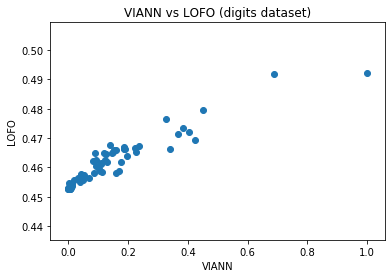

0.9376833451149439


In [27]:
modelname = "NN2"
datname = VIANN_NN2[1][0]
xx = VIANN_NN2[1][1]
yy = LOFO_NN2[1][1][0]

f = plt.figure()
plt.scatter(xx, yy)
plt.xlabel('VIANN')
plt.ylabel('LOFO')
plt.title('VIANN vs LOFO' + " (" + datname + " dataset)")
plt.show()
f.savefig("VIANNvsLOFO_" + datname + "_" + modelname +".pdf")

print(np.corrcoef([xx,yy])[0,1])

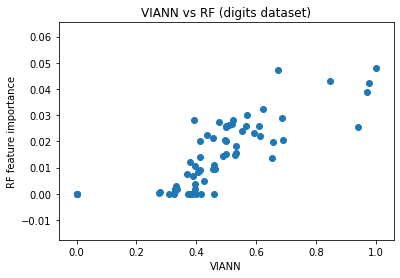

0.7976443040852133


In [33]:
modelname = "DeepNN"
datname = VIANN_DeepNN[1][0]
xx = VIANN_DeepNN[1][1]
yy = RF[1][1]

f = plt.figure()
plt.scatter(xx, yy)
plt.xlabel('VIANN')
plt.ylabel('RF feature importance')
plt.title('VIANN vs RF' + " (" + datname + " dataset)")
plt.show()
f.savefig("VIANNvsRF_" + datname + "_" + modelname +".pdf")

print(np.corrcoef([xx,yy])[0,1])